In [1]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis/')

In [48]:
import pandas as pd
import TimeSeriesAnalysis.tsa_lth.analysis as analysis
import TimeSeriesAnalysis.tsa_lth.modelling as modelling
import TimeSeriesAnalysis.tsa_lth.tests as tests
from TimeSeriesAnalysis.tsa_lth.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import copy
import pylab

# Import data

In [3]:
ElGeneina_mat = analysis.mat2np('./data/ElGeneina.mat')[0]
Kassala_mat = analysis.mat2np('./data/Kassala.mat')[0]

In [4]:
ElGeneina = pd.DataFrame()
col_names = ['nvdi', 'nvdi_t', 'rain', 'rain_t', 'rain_org', 'rain_org_t']
for i in range(len(ElGeneina_mat)):
    ElGeneina = pd.concat([ElGeneina, pd.DataFrame(ElGeneina_mat[i]).astype(float).round(6)], axis=1, ignore_index=True)
ElGeneina.columns = col_names
    
Kassala = pd.DataFrame()
for i in range(len(Kassala_mat)):
    Kassala = pd.concat([Kassala, pd.DataFrame(Kassala_mat[i]).astype(float).round(6)], axis=1, ignore_index=True)
Kassala.columns = col_names
Kassala.head(10)

,nvdi,nvdi_t,rain,rain_t,rain_org,rain_org_t
0,146.0,1982.013889,0.0,1960.013889,0.0,1960.041667
1,147.9,1982.041667,0.0,1960.041667,0.0,1960.125000
2,142.4,1982.069444,0.0,1960.069444,0.0,1960.208333
3,143.0,1982.097222,0.0,1960.097222,0.0,1960.291667
4,144.3,1982.125000,0.0,1960.125000,16.5,1960.375000
5,142.6,1982.152778,0.0,1960.152778,40.1,1960.458333
6,139.1,1982.180556,0.0,1960.180556,92.0,1960.541667
7,143.7,1982.208333,0.0,1960.208333,46.8,1960.625000
8,145.9,1982.236111,0.0,1960.236111,97.9,1960.708333
9,138.7,1982.263889,0.0,1960.263889,0.0,1960.791667


- High NDVI indicates presence of vegetation
- Low NDVI indicates barren ground, water, snow, ice, etc
- NDVI are stored as unsigned (8-bit) integers (i.e., between 0 and 255), and thus needs to be rescaled to [−1,1].
- NDVI is measured three times every month (day 1-10, 11-20, 21-end) 
- Rain_org is measured once every month
- Rain is linear interpolation of Rain_org to match NDVI
- Both NDVI and rain data had missing data points but were filled with Matlab misdata function.

# Recursive reconstruction of rain data

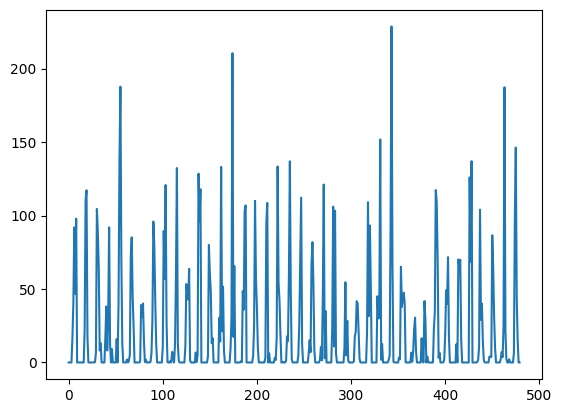

In [5]:
plt.plot(Kassala['rain_org'])
plt.show()

In [30]:
# Here we add a very small value to allow y to be strictly positive.
y = Kassala['rain_org'].values
y = y[:len(y)-960]
y = y + 1e-8

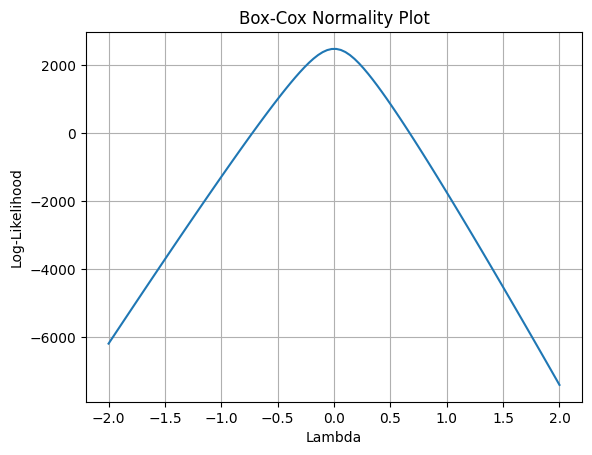

Max Lambda = 0.0019948143353221213.
ln(y) could be an appropriate transformation.


In [31]:
max_lambda = analysis.box_cox(y, 1)

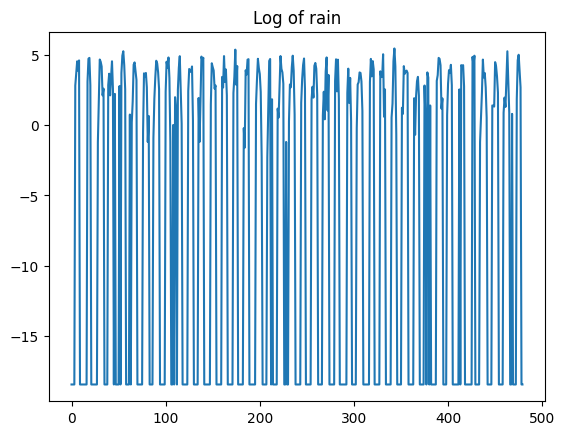

In [32]:
plt.plot(np.log(y))
plt.title('Log of rain')
plt.show()

In [9]:
Kassala[['rain_org_t', 'rain_org']].rename(columns={'rain_org_t':'t'})

,t,rain_org
0,1960.041667,0.0
1,1960.125000,0.0
2,1960.208333,0.0
3,1960.291667,0.0
4,1960.375000,16.5
...,...,...
1435,NaN,NaN
1436,NaN,NaN
1437,NaN,NaN
1438,NaN,NaN


In [39]:
Kassala[Kassala['rain_org_t']>1999]

,nvdi,nvdi_t,rain,rain_t,rain_org,rain_org_t
468,153.2,1995.013889,0.000000,1973.013889,2.2,1999.041667
469,152.0,1995.041667,0.000000,1973.041667,0.0,1999.125000
470,151.8,1995.069444,0.000000,1973.069444,0.0,1999.208333
471,147.8,1995.097222,0.000000,1973.097222,0.0,1999.291667
472,150.4,1995.125000,0.000000,1973.125000,0.0,1999.375000
473,147.9,1995.152778,0.000000,1973.152778,6.3,1999.458333
474,150.9,1995.180556,0.000000,1973.180556,98.8,1999.541667
475,149.4,1995.208333,0.000000,1973.208333,146.3,1999.625000
476,143.2,1995.236111,0.000000,1973.236111,43.3,1999.708333
477,144.7,1995.263889,0.000000,1973.263889,14.6,1999.791667


In [37]:
np.isnan(1)

False

In [46]:
test = pd.merge(Kassala['rain_t'], Kassala[['rain_org_t', 'rain_org']], how='outer', left_on='rain_t', right_on='rain_org_t').sort_values('rain_t')
test = test.dropna(axis=0, how='all')
y = test['rain_org'].values
# scale = lambda x: np.log(x)+1e-8 if np.isnan(x) else x
# scale(y)
test['rain_org'] = test['rain_org'].apply(lambda x: np.log(x+1e-8) if pd.notnull(x) else x)
y = test['rain_org'].values
test.tail(15)

,rain_t,rain_org_t,rain_org
1425,1999.597222,NaN,NaN
1426,1999.625000,1999.625000,4.985659
1427,1999.652778,NaN,NaN
1428,1999.680556,NaN,NaN
1429,1999.708333,1999.708333,3.768153
1430,1999.736111,NaN,NaN
1431,1999.763889,NaN,NaN
1432,1999.791667,1999.791667,2.681022
1433,1999.819444,NaN,NaN
1434,1999.847222,NaN,NaN


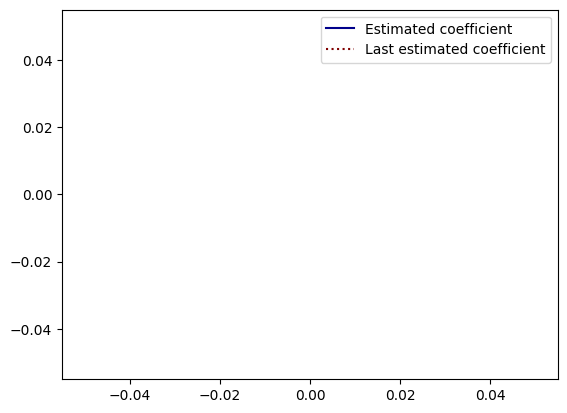

In [62]:
# Using log transformed data perform kalman gain to get the AR(1) coefficient
N = len(y)
A = np.array([1])
Re = [0]
Rw = 1.25

Rxx1 = [10]
xtt1 = np.array([0])

Xsave = np.zeros((1, N))
ehat = np.zeros(N)
yhat = np.zeros(N)
yt1 = np.zeros(N)
yt2 = np.zeros(N)
y1 = copy.deepcopy(y)

for t in range(1, N):
    Ct = np.array([y1[t-1]])
    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    Kt = np.dot(np.dot(Rxx1, Ct.T), [1/Ryy[0]])
    yhat[t] = np.dot(Ct, xtt1).item()
    
    if np.isnan(y[t]):
        xtt = xtt1
        Rxx = Rxx1
        y1[t] = yhat[t]
    else:
        ehat[t] = y[t] - yhat[t]
        xtt = xtt1 + np.dot(Kt, ehat[t])
        Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)

    xtt1 = np.dot(A, xtt)
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re
    # print(xtt)
    Xsave[:, t] = xtt.flatten()
    
# Plot the estimated ar coeffecient
plt.plot(Xsave[0], color='darkblue', label='Estimated coefficient')
plt.axhline(Xsave[0][-1], color='maroon', linestyle='dotted', label='Last estimated coefficient')
plt.legend()
plt.show()

In [59]:
Xsave[0][:7]

array([ 0., nan, nan, nan, nan, nan, nan])

In [52]:
y1

array([         nan, -18.42068074,          nan, ...,          nan,
       -18.42068074,          nan])